In [1]:
# ===================================================================================================
# INITIALISATION
# ===================================================================================================
#
# Purpose:
# - Flexible create, save, restore and prediction with a character-level sequence to sequence model
#
# Based on:
# - https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
# - https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq_restore.py
#
# Save / Load from:
# - https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
#
# NOTE: Saving / Loading doesn't work. In progress...

In [2]:
from __future__ import print_function

import datetime

from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

import keras
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import numpy as np

d:\projects\007-anaconda\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
print("Tensorflow Version:",tf.__version__)
print("Keras Version:", keras.__version__)
print("Keras Backend:", keras.backend.backend())
print(datetime.datetime.now())

Tensorflow Version: 1.8.0
Keras Version: 2.1.6
Keras Backend: tensorflow
2018-06-06 21:46:08.081181


In [4]:
# Helper modules - exporting complexity out of the file.
from chardict import *
from textimport import *

In [5]:
# ===================================================================================================
# LOAD & SETUP DATA - Multiple Files
# ===================================================================================================

In [6]:
# load the Q/A sentence files
q_filelist = glob.glob("../001-CorpusData/004-Dialog/002-Exchanges/simpledialog-*q.txt")
a_filelist = glob.glob("../001-CorpusData/004-Dialog/002-Exchanges/simpledialog-*a.txt")

print(q_filelist[0])
print(a_filelist[0])

../001-CorpusData/004-Dialog/002-Exchanges\simpledialog-q.txt
../001-CorpusData/004-Dialog/002-Exchanges\simpledialog-a.txt


In [7]:
# take the book list, and create a list of text sentences
full_qlinelist = []
full_alinelist = []
for currfile in q_filelist:
    print("Processing q-file: {}".format(currfile))
    full_qlinelist.extend(import_textfile_to_linelist(currfile))
for currfile in a_filelist:
    print("Processing a-file: {}".format(currfile))
    full_alinelist.extend(import_textfile_to_linelist(currfile))
    
formattedfull_alinelist = []     
for eachline in full_alinelist:
    formatted_eachline = '\t' + eachline + '\n'
    formattedfull_alinelist.append(formatted_eachline)
    
print("q-linelist total:{}".format(len(full_qlinelist)))
print("a-linelist total:{}".format(len(full_alinelist)))

# Vectorize the input text
input_texts       = []
target_texts      = []
input_texts.extend(full_qlinelist)
target_texts.extend(formattedfull_alinelist)

print (input_texts[:10])

Processing q-file: ../001-CorpusData/004-Dialog/002-Exchanges\simpledialog-q.txt
Processing a-file: ../001-CorpusData/004-Dialog/002-Exchanges\simpledialog-a.txt
q-linelist total:59
a-linelist total:59
['Good morning, how are you?', 'I am doing well, how about you?', "I'm also good.", "That's good to hear.", 'Hello.', 'Hi.', 'How are you doing?', 'I am doing well.', 'That is good to hear.', 'Yes it is.']


In [8]:
# ===================================================================================================
# LOAD & SETUP DATA - Single Source
# ===================================================================================================

In [9]:
# Get a character dictionary, prepopulated with common letters for clarity
chardict = chardict_standardprepop()

# Go through the inputs, adding any extra characters we'll need
for line in input_texts:
    #print (line)
    for char in line:
        #print (char)
        chardict_id_for_char(chardict, char)
for line in target_texts:
    for char in line:
        chardict_id_for_char(chardict, char)

# Create the reverse lookup dictionary for decoding later        
rev_chardict = chardict_reverse_dict(chardict)

# Numbers to feed into model definition
num_tokens             = len(chardict) + 1
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

# Debug print some value for confidence
print('Number of input samples:',         len(input_texts))
print('Number of output samples:',        len(target_texts))
print('Number of tokens:',                num_tokens)
print('Max sequence length for inputs:',  max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print(chardict)
print(rev_chardict)

Number of input samples: 59
Number of output samples: 59
Number of tokens: 98
Max sequence length for inputs: 54
Max sequence length for outputs: 79
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61, '0': 62, ' ': 63, '!': 64, '?': 65, '£': 66, '$': 67, '€': 68, '^': 69, '&': 70, '*': 71, '(': 72, ')': 73, '[': 74, ']': 75, '{': 76, '}': 77, '<': 78, '>': 79, '-': 80, '=': 81, ';': 82, ':': 83, '@': 84, '#': 85, '~': 86, ',': 87, '.': 88, '_': 89, '+': 90, '¬': 91, '/': 92, '\\': 93, '|': 94, '\n': 95, '\

In [10]:
# ===================================================================================================
# DEFINE MODEL
# ===================================================================================================

In [11]:
# updatable plot# updat 
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):

    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    def on_train_begin(self, logs={}):
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [12]:
latent_dim  = 256   # Latent dimensionality of the encoding space.

In [13]:
encoder_input_data  = np.zeros((len(input_texts),  max_encoder_seq_length, num_tokens), dtype='float32')
decoder_input_data  = np.zeros((len(target_texts), max_decoder_seq_length, num_tokens), dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, chardict[char]] = 1.
        
    for t, char in enumerate(target_text):
        #print(i, t, char, chardict[char])
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, chardict[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, chardict[char]] = 1.

In [14]:
# Define an input sequence and process it.
encoder_inputs                    = Input(shape=(None, num_tokens),     name='encoder_inputs')
encoder                           = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_tokens), name='decoder_inputs')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm          = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense         = Dense(num_tokens, activation='softmax', name='decoder_dense')
decoder_outputs       = decoder_dense(decoder_outputs)

In [15]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 98)     0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 98)     0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 363520      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  363520      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]               
          

In [ ]:
# DONT RUN
model.load_weights('040-weightsfile_chat.h5')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

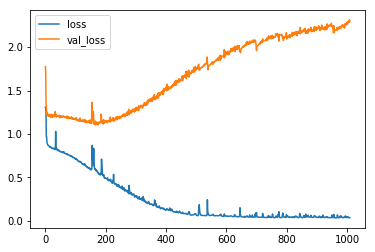

In [17]:
epochs     = 1000  # Number of epochs to train for.
batch_size = 100   # Batch size for training.

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[plot_losses])

In [ ]:
# Save model
model.save_weights('040-weightsfile_chat_100.h5')

In [18]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states  = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model   = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [19]:
# Decodes an input sequence.  Future work should support beam search.
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, chardict['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char        = rev_chardict[sampled_token_index]
        decoded_sentence   += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [20]:
predict_range = min(100, len(encoder_input_data)-1)
for seq_index in range(predict_range):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Good morning, how are you?
Decoded sentence: I am doing well.

-
Input sentence: I am doing well, how about you?
Decoded sentence: That is good to hear.

-
Input sentence: I'm also good.
Decoded sentence: A man in a mask.

-
Input sentence: That's good to hear.
Decoded sentence: What is it like?

-
Input sentence: Hello.
Decoded sentence: What is it like?

-
Input sentence: Hi.
Decoded sentence: That is good to hear.

-
Input sentence: How are you doing?
Decoded sentence: I am doing well.

-
Input sentence: I am doing well.
Decoded sentence: That is good to hear.

-
Input sentence: That is good to hear.
Decoded sentence: What is it like?

-
Input sentence: Yes it is.
Decoded sentence: What good news?

-
Input sentence: Can I help you with anything?
Decoded sentence: Yes it is.

-
Input sentence: Yes, I have a question.
Decoded sentence: What good news?

-
Input sentence: What is your question?
Decoded sentence: I am doing well, how about you?

-
Input sentence: Could 

In [21]:
# Manual text input and prediction
running = True

while (running):
    
    # Get a new line of text to process
    newinput_line = input("enter text:")
    
    # Exit if its too short to be valid
    if len(newinput_line) < 2:
        print("<ending>")
        break
        
    encoder_input_line  = np.zeros((1,  max_encoder_seq_length, num_tokens), dtype='float32')
    
    for t, char in enumerate(newinput_line):
        encoder_input_line[0, t, chardict[char]] = 1.
    
    decoded_sentence = decode_sequence(encoder_input_line)
    print('-')
    print('Input sentence:', newinput_line)
    print('Decoded sentence:', decoded_sentence)
    

enter text:Good morning, how are you?
-
Input sentence: Good morning, how are you?
Decoded sentence: I am doing well.

enter text:
<ending>
